Trying out the RNNCell module on MNIST dataset. A single-layer RNN is formed which is fed with the image's rows (28 in total) one at a time as sequential data. Of course, this is not the optimal way to deal with static computer vision tasks.

In [1]:
% matplotlib inline
from tqdm.notebook import trange
import torch
import torch.nn as nn
import torchvision
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
train_dataset = datasets.MNIST(root='./', download=True, train=True, transform=transforms.ToTensor())
test_dataset = datasets.MNIST(root='./', download=True, train=False, transform=transforms.ToTensor())

x_train = train_dataset.data.float()
y_train = train_dataset.targets
y_train_ohe = torch.nn.functional.one_hot(y_train)

In [3]:
max_epochs = 100
batch_size = 64

In [4]:
class rnn(nn.Module):
    def __init__(self):
        super().__init__()
        self.cell = nn.RNNCell(input_size=28, hidden_size=28, nonlinearity='tanh')
        self.fc = nn.Linear(28, 10)

    def forward(self, x):
        bs = x.shape[0]
        hidden = torch.zeros((bs, 28)).to(device)
        for i in range(28):
            hidden = self.cell(x[:, i, :], hidden)
        x = self.fc(hidden)
        return x

In [5]:
train_dl = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size)
test_dl = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size)

In [6]:
model = rnn().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

test_acc = 0  # this one is not appended - it's just used as a starting point for t.set_description
losses = []
train_accuracies = []
test_accuracies = []

for epoch in (t := trange(max_epochs)):
    running_loss = 0
    running_train_acc = 0
    running_test_acc = 0
    for image, label in train_dl:
        image = image.squeeze(1).to(device)
        label = label.to(device)
        model.zero_grad()

        output = model(image)
        predicted_class = torch.argmax(output, dim=1)
        train_acc = (predicted_class == label).float().mean()
        running_train_acc += train_acc.item()

        loss = criterion(output, label)
        running_loss += loss.item()

        loss.backward()
        optimizer.step()

        t.set_description(f'Train loss: {loss.item():.4f} | Train acc: {train_acc * 100:.2f}% | Test acc: {test_acc * 100:.2f}%')

    with torch.no_grad():
        for batch, (image_t, label_t) in enumerate(test_dl):
            image_t = image_t.squeeze(1).to(device)
            label_t = label_t.to(device)
            output = model(image_t)

            predicted_class_t = torch.argmax(output, dim=1)
            test_acc = (predicted_class_t == label_t).float().mean()
            running_test_acc += test_acc.item()

    losses.append(running_loss / len(train_dl))
    train_accuracies.append(running_train_acc / len(train_dl))
    test_accuracies.append(running_test_acc / len(test_dl))

  0%|          | 0/100 [00:00<?, ?it/s]

Text(0, 0.5, 'Loss')

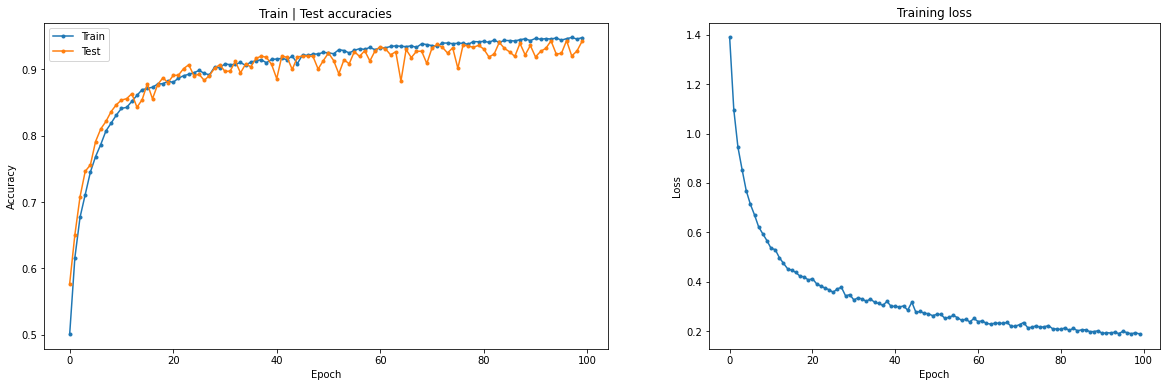

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(20, 6), gridspec_kw={'width_ratios': [5, 4]})

ax[0].plot(train_accuracies, '.-')
ax[0].plot(test_accuracies, '.-')
ax[0].set_title('Train | Test accuracies')
ax[0].legend(['Train', 'Test'])
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Accuracy')

ax[1].plot(losses, '.-')
ax[1].set_title('Training loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')

The model was trained for 100 epochs and there might still be room for improvement (it's not clear whether the model has overfit the training dataset).